In [17]:
from qiskit import Aer

In [18]:
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA

import numpy as np
import matplotlib.pyplot as plt
import datetime

In [37]:
num_assets = 4

stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks, start=datetime.datetime(2016, 1, 1),
                         end = datetime.datetime(2016, 1, 30)
                         )
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [38]:
# print(stocks)
# print(data)
# mu
# sigma*100000

array([[167.58358646,  -1.53006813, -12.27205628,  56.6302015 ],
       [ -1.53006813,  14.73829649,  -0.55179862,   9.41338944],
       [-12.27205628,  -0.55179862,  56.98355639, -51.02582236],
       [ 56.6302015 ,   9.41338944, -51.02582236, 459.5770614 ]])

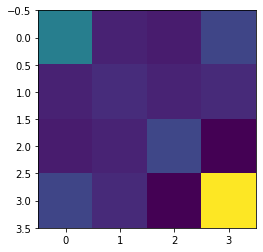

In [39]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [23]:
# print(sigma)

[[ 2.38473305e-04  6.19108846e-05  7.61177842e-05  7.22963439e-05]
 [ 6.19108846e-05  5.90317959e-04  9.77507330e-05 -4.55883432e-05]
 [ 7.61177842e-05  9.77507330e-05  2.47249984e-04 -5.61295463e-05]
 [ 7.22963439e-05 -4.55883432e-05 -5.61295463e-05  2.73247120e-03]]


In [24]:
q = 0.5
budget = num_assets//2
penalty = num_assets

qubitOp, offset= portfolio.get_operator(mu, sigma, q, budget, penalty)

In [32]:
print(qubitOp)

Representation: paulis, qubits: 4, size: 10


In [25]:
def index_of_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n------------Full result-------------')
    print('selection\tvalue\t\tprobability')
    print('--------------------------------------')
    for i in i_sorted:
        x = index_of_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [26]:
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)

Optimal: selection [0 1 0 1], value -0.0017

------------Full result-------------
selection	value		probability
--------------------------------------
 [0 1 0 1]	-0.0017		1.0000
 [1 1 1 1]	16.0011		0.0000
 [0 1 1 1]	3.9986		0.0000
 [1 0 1 1]	4.0013		0.0000
 [0 0 1 1]	-0.0012		0.0000
 [1 1 0 1]	4.0008		0.0000
 [1 0 0 1]	0.0010		0.0000
 [0 0 0 1]	3.9987		0.0000
 [1 1 1 0]	4.0024		0.0000
 [0 1 1 0]	-0.0000		0.0000
 [1 0 1 0]	0.0026		0.0000
 [0 0 1 0]	4.0002		0.0000
 [1 1 0 0]	0.0021		0.0000
 [0 1 0 0]	3.9997		0.0000
 [1 0 0 0]	4.0023		0.0000
 [0 0 0 0]	16.0000		0.0000


In [31]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0017

------------Full result-------------
selection	value		probability
--------------------------------------
 [0 1 0 1]	-0.0017		0.1669
 [0 0 1 1]	-0.0012		0.1668
 [0 1 1 0]	-0.0000		0.1667
 [1 0 0 1]	0.0010		0.1666
 [1 1 0 0]	0.0021		0.1665
 [1 0 1 0]	0.0026		0.1665
 [0 0 0 1]	3.9987		0.0000
 [0 0 0 0]	16.0000		0.0000
 [0 1 0 0]	3.9997		0.0000
 [0 1 1 1]	3.9986		0.0000
 [0 0 1 0]	4.0002		0.0000
 [1 1 1 1]	16.0011		0.0000
 [1 0 0 0]	4.0023		0.0000
 [1 1 1 0]	4.0024		0.0000
 [1 1 0 1]	4.0008		0.0000
 [1 0 1 1]	4.0013		0.0000


In [28]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0017

------------Full result-------------
selection	value		probability
--------------------------------------
 [0 1 0 1]	-0.0017		0.1669
 [0 0 1 1]	-0.0012		0.1668
 [0 1 1 0]	-0.0000		0.1667
 [1 0 0 1]	0.0010		0.1666
 [1 1 0 0]	0.0021		0.1665
 [1 0 1 0]	0.0026		0.1665
 [0 0 0 1]	3.9987		0.0000
 [0 0 0 0]	16.0000		0.0000
 [0 1 0 0]	3.9997		0.0000
 [0 1 1 1]	3.9986		0.0000
 [0 0 1 0]	4.0002		0.0000
 [1 1 1 1]	16.0011		0.0000
 [1 0 0 0]	4.0023		0.0000
 [1 1 1 0]	4.0024		0.0000
 [1 1 0 1]	4.0008		0.0000
 [1 0 1 1]	4.0013		0.0000
